<a href="https://colab.research.google.com/github/ashaduzzaman-sarker/Object-detection/blob/main/Keypoint_Detection_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a keypoint detector with data augmentation and transfer learning.

**Author:** [Ashaduzzaman Sarker](https://github.com/ashaduzzaman-sarker/)
<br>
**Date created:** 10/07/2024
<br>
**Reference:** [Keras Example](https://keras.io/examples/vision/keypoint_detection/)


## Instalments

In [1]:
# Upgrade keras
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 37.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [2]:
# installing imgaug library
!pip install -q -U imgaug

## Download Stanford dogs dataset

In [3]:
# Stanford dogs dataset download
!wget -q http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

In [4]:
# extract the archives
!tar -xf images.tar

In [9]:
# Extract locally available stanfordextra_v12.zip
# https://drive.google.com/file/d/1v5w2lMfjE3FZRPXsJKUli7NaKhVFvBGj/view?usp=sharing
!unzip -qq stanfordextra_v12.zip

## Imports

In [10]:
from keras import layers
import keras

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

## Define Hyperparameters

In [11]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 5
NUM_KEYPOINTS = 24 * 2  # 24 pairs each having x and y coordinates

## Load Data

In [12]:
IMG_DIR = 'Images'
JSON = 'StanfordExtra_V12/StanfordExtra_v12.json'
KEYPOINT_DEF = (
    'https://github.com/benjiebob/StanfordExtra/raw/master/keypoint_definitions.csv'
)

# Load the ground-truth annotations
with open(JSON) as infile:
  json_data = json.load(infile)

# Dictionary mapping ground-truth info with respect to image path
json_dict = {i['img_path']: i for i in json_data}

In [13]:
# Load the metadata definition file and preview it
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

,Index,Name,Hex colour,Stanford,Animal-pose,(name in animal pose)
0,0,Left front leg: paw,d82400,y,y,L_F_Paw
1,1,Left front leg: middle joint,d82400,y,y,L_F_Knee
2,2,Left front leg: top,d82400,y,y,L_F_Elbow
3,3,Left rear leg: paw,fcfc00,y,y,L_B_Paw
4,4,Left rear leg: middle joint,fcfc00,y,y,L_B_Knee


In [14]:
# Extract the colours and labels
colours = keypoint_def['Hex colour'].values.tolist()
colours = ['#' + colour for colour in colours]
labels = keypoint_def['Name'].values.tolist()

# Utility for reading an image and for gettind its annotations
def get_dog(name):
  data = json_dict[name]
  img_data = plt.imread(os.path.join(IMG_DIR, data['img_path']))

  # If the image is RGBA convert it to RGB
  if img_data.shape[-1] == 4:
    img_data = img_data.astype(np.uint8)
    img_data = Image.fromarray(img_data)
    img_data = np.array(img_data.convert('RGB'))
  data['img_data'] = img_data

  return data

## Visualize Data

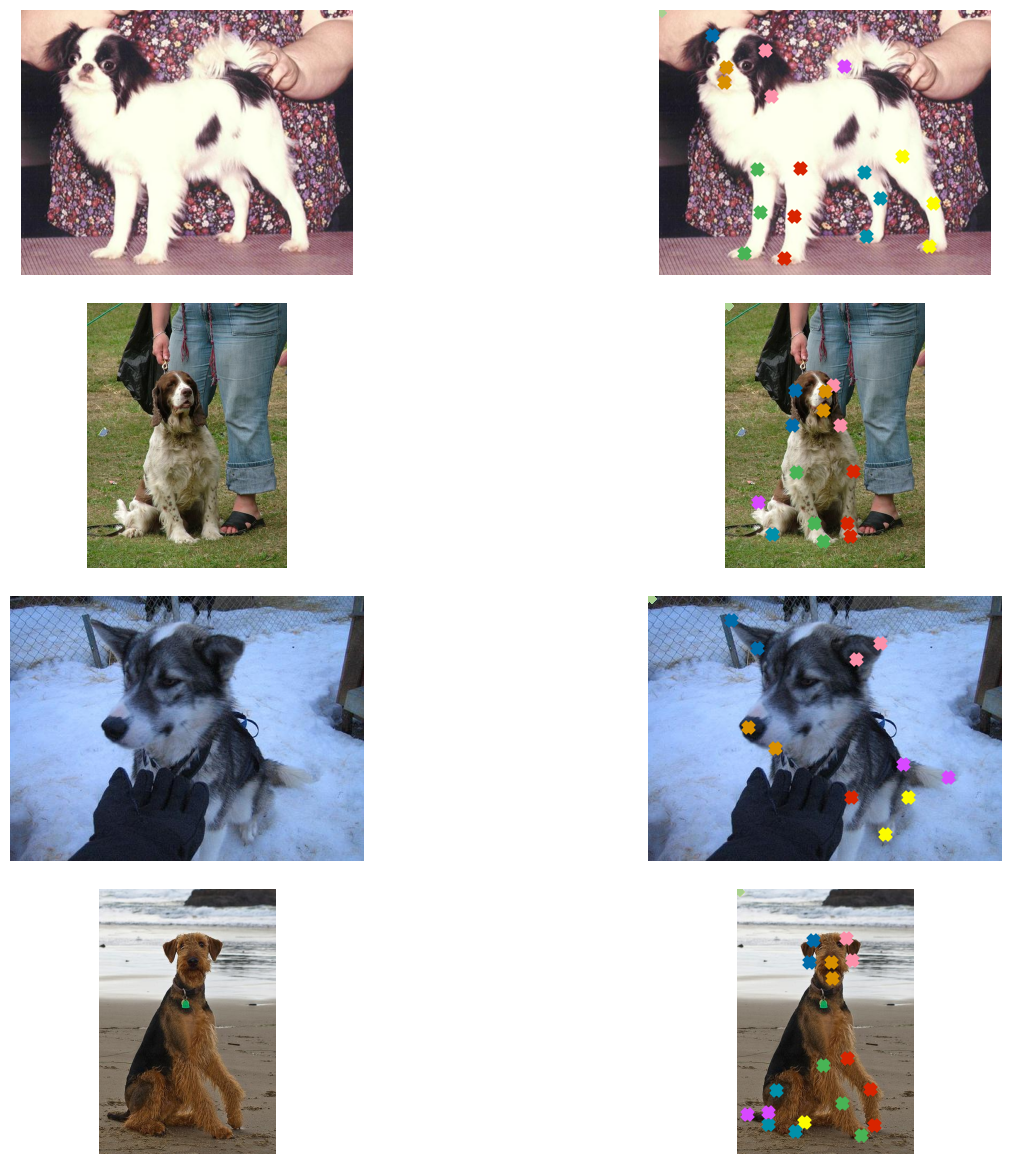

In [15]:
def visualize_keypoints(images, keypoints):
  fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
  [ax.axis('off') for ax in np.ravel(axes)]

  for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
    ax_orig.imshow(image)
    ax_all.imshow(image)

    if isinstance(current_keypoint, KeypointsOnImage):
      for idx, kp in enumerate(current_keypoint.keypoints):
        ax_all.scatter(
            [kp.x],
            [kp.y],
            c=colours[idx],
            marker='x',
            s=50,
            linewidths=5,
        )
    else:
      current_keypoint = np.array(current_keypoint)
      current_keypoint = current_keypoint[:, :2]
      for idx, (x, y) in enumerate(current_keypoint):
          ax_all.scatter([x], [y], c=colours[idx], marker='x', s=50, linewidths=5)

  plt.tight_layout(pad=2.0)
  plt.show()

# Select four samples randomly for visualization
samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
  data = get_dog(sample)
  image = data['img_data']
  keypoint = data['joints']

  images.append(image)
  keypoints.append(keypoint)

visualize_keypoints(images, keypoints)


## Prepare Data Generator

In [16]:
class KeyPointsDataset(keras.utils.PyDataset):
  def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True, **kwargs):
    super().__init__(**kwargs)
    self.image_keys = image_keys
    self.aug = aug
    self.batch_size = batch_size
    self.train = train
    self.on_epoch_end()

  def __len__(self):
    return len(self.image_keys) // self.batch_size

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.image_keys))
    if self.train:
      np.random.shuffle(self.indexes)

  def __getitem__(self, index):
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
    image_keys_temp = [self.image_keys[k] for k in indexes]
    (images, keypoints) = self.__data_generation(image_keys_temp)

    return (images, keypoints)

  def __data_generation(self, image_keys_temp):
    batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype='int')
    batch_keypoints = np.empty((self.batch_size, 1, 1, NUM_KEYPOINTS), dtype='float32')

    for i, key in enumerate(image_keys_temp):
      data = get_dog(key)
      current_keypoint = np.array(data['joints'])[:, :2]
      kps = []

      for j in range(0, len(current_keypoint)):
        kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

      current_image = data['img_data']
      kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

      (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
      batch_images[i,] = new_image

      kp_temp = []
      for keypoint in new_kps_obj:
        kp_temp.append(np.nan_to_num(keypoint.x))
        kp_temp.append(np.nan_to_num(keypoint.y))

      batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 24 * 2)

    batch_keypoints = batch_keypoints / IMG_SIZE

    return (batch_images, batch_keypoints)

## Define augmentation transforms

In [17]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation='linear'),
        iaa.Fliplr(0.3),
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation='linear')])

## Create training and validation splits

In [18]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)

## Data generator investigation

Total batches in training set: 166
Total batches in validation set: 29


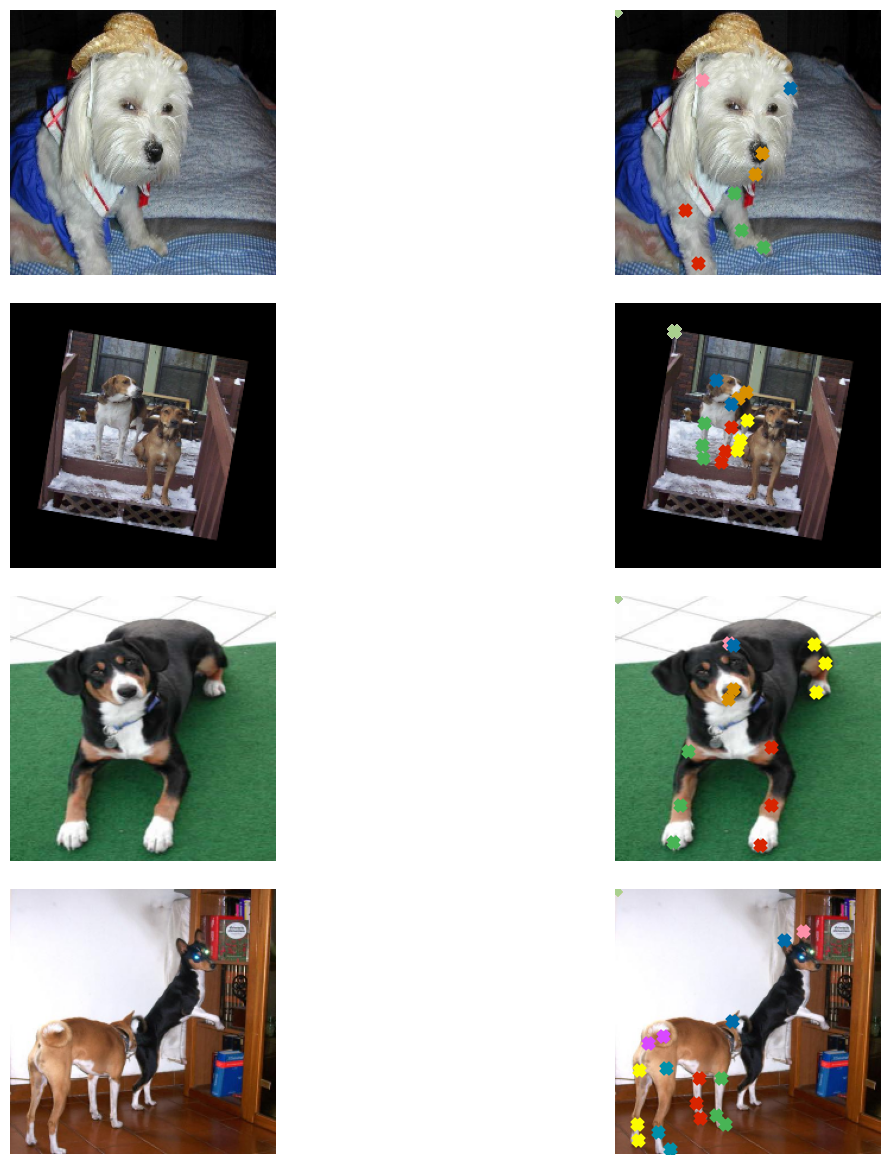

In [19]:
train_dataset = KeyPointsDataset(
    train_keys, train_aug, workers=2, use_multiprocessing=True
)

validation_dataset = KeyPointsDataset(
    validation_keys, test_aug, train=False, workers=2, use_multiprocessing=True
)

print(f'Total batches in training set: {len(train_dataset)}')
print(f'Total batches in validation set: {len(validation_dataset)}')

sample_images, sample_keypoints = next(iter(train_dataset))
assert sample_keypoints.max() == 1.0
assert sample_keypoints.min() == 0.0

sample_keypoints = sample_keypoints[:4].reshape(-1, 24, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

## Model building

In [20]:
# Load the pretrained weights of MobileNetV2 and freeze the weights
def get_model():
  backbone = keras.applications.MobileNetV2(
      weights='imagenet',
      include_top=False,
      input_shape=(IMG_SIZE, IMG_SIZE, 3),
  )
  backbone.trainable = False

  inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
  x = keras.applications.mobilenet_v2.preprocess_input(inputs)
  x = backbone(x)
  x = layers.Dropout(0.3)(x)
  x = layers.SeparableConv2D(
      NUM_KEYPOINTS, kernel_size=3, strides=1, activation='relu'
  )(x)
  outputs = layers.SeparableConv2D(
      NUM_KEYPOINTS, kernel_size=5, strides=1, activation='sigmoid'
  )(x)

  return keras.Model(inputs, outputs, name='keypoint_detector')

In [21]:
get_model().summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "keypoint_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 5, 5, 48)            │          73,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_1 (SeparableConv2D) │ (None, 1, 1, 48)            │           3,552 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,334,544 (8.91 MB)

 Trainable params: 76,560 (299.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Model compilation and training

In [22]:
model = get_model()

model.compile(
    loss='mse',
    optimizer=keras.optimizers.Adam(1e-4),
)

model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)

Epoch 1/5


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


158/166 ━━━━━━━━━━━━━━━━━━━━ 6s 769ms/step - loss: 0.1092

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


166/166 ━━━━━━━━━━━━━━━━━━━━ 187s 907ms/step - loss: 0.1088 - val_loss: 0.0863
Epoch 2/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - loss: 0.0815 - val_loss: 0.0785
Epoch 3/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 178s 935ms/step - loss: 0.0777 - val_loss: 0.0758
Epoch 4/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 201s 926ms/step - loss: 0.0756 - val_loss: 0.0724
Epoch 5/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 154s 882ms/step - loss: 0.0738 - val_loss: 0.0694


## Make predictions and visualize them

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


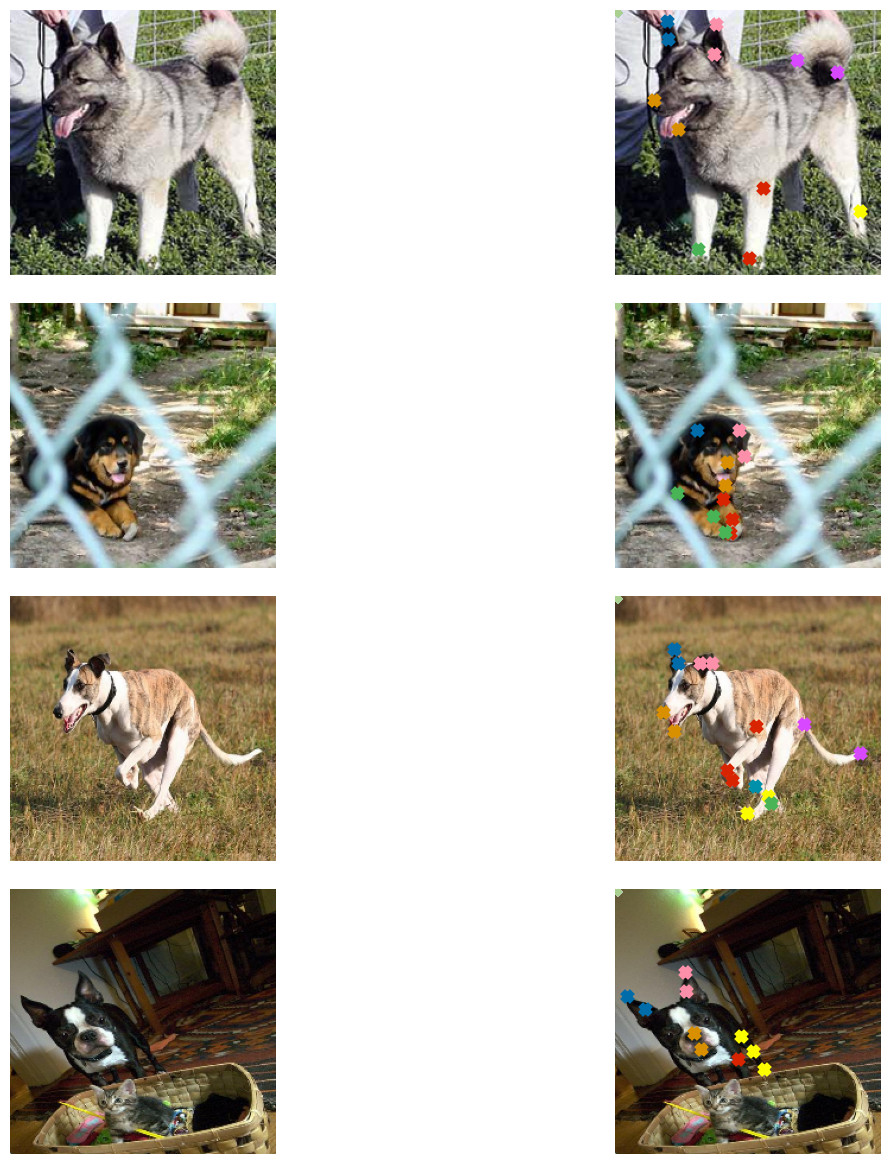

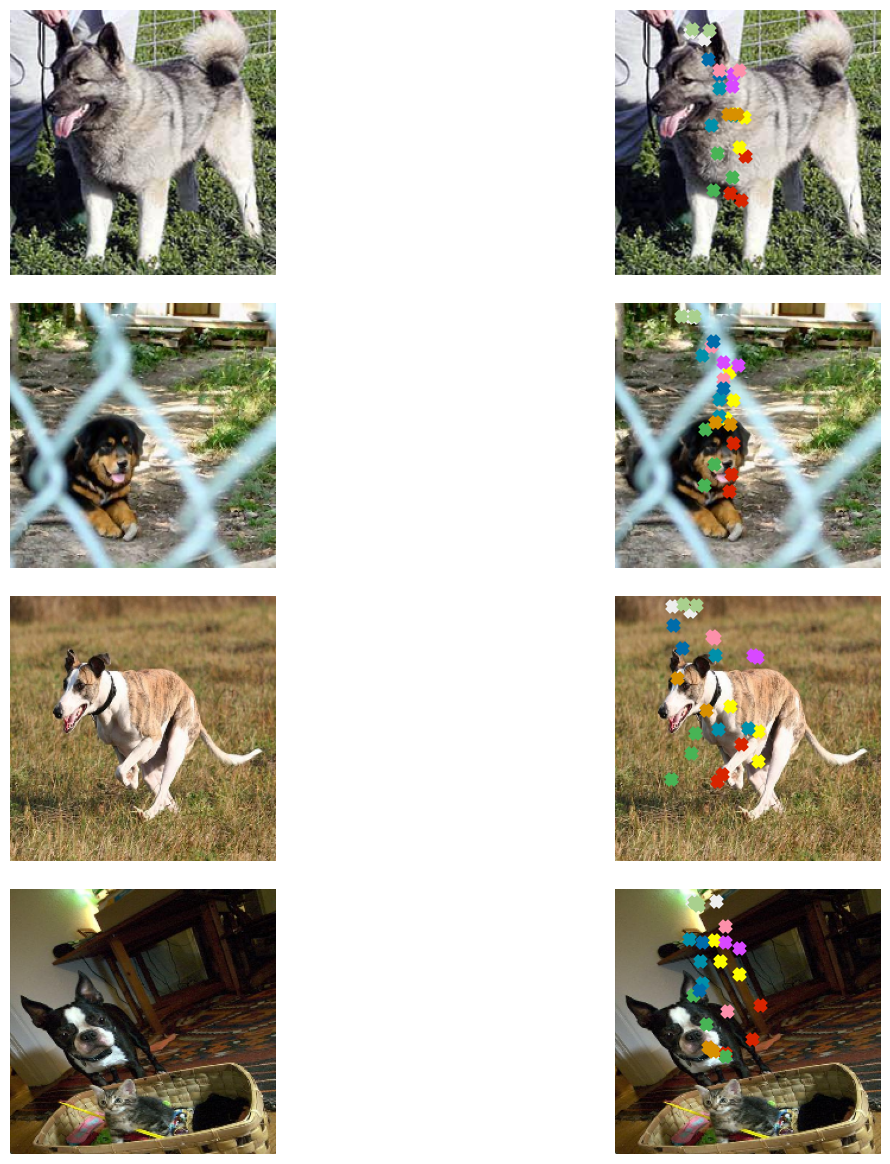

In [23]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 24, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 24, 2) * IMG_SIZE

visualize_keypoints(sample_val_images, sample_val_keypoints)

visualize_keypoints(sample_val_images, predictions)